# STROKE PREDICTION MODEL

In this model, I will create a model that can be used to predict whether an individual has stroke.

This model will also incorporate feature selection using wrappers:
1. Sequential Forward Search(SFS)
2. Backward Elimination.(BE)

I will use the `mlxtend` library alonside ` sklearn` for this exercise. The `sklearn` library does not provide comprehensive Wrapper feature selection

`In this exercise I will not perform EDA as I had already perfomed it in another notebook.`
## 1. IMPORTING THE LIBRARIES.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from mlxtend.plotting import plot_sequential_feature_selection as psfs
from matplotlib.ticker import MaxNLocator


## 2. LOADING THE DATASET

In [2]:
data = pd.read_csv('stroke prediction.csv')
# printing the shape of the data
print(data.shape)
# printing the first five rows
data.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

The dataset is imbalanced and I might need to balance it. This will however happen the next notebook.

## 3. DATA PREPARATION

1. Handling outliers in the avg_glucose_level and bmi columns and replacing the `missing values in the bmi column using the mean`
2. Using OneHotEncoding and LabelEncoder to convert categorical columns into numerical format.
2. Extract the data from the dataframe into numpy arrays
3. Split into train and test splits
4. Apply MinMaxScaler to normalize the data

In [4]:
# Replacing the empty cells using the mean.
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

# handling the outliers in the avg_glucose_level and bmi columns

# The code below replaces any values > 43 and < 12 with the mean of the BMI column. 

data['bmi'] = np.where(
    data['bmi'] > 43,
    data['bmi'].mean(),
    np.where(
        data['bmi'] < 12,
        data['bmi'].mean(),
        data['bmi']
    )
)

# Calculating the average for mean and mode of the avg_glucose_level column.

avg = (data['avg_glucose_level'].mean() + data['avg_glucose_level'].mode())/2

# Replacing all values greater than 170 in the avg_glucose_level with the average for mean and mode of the column.

data['avg_glucose_level'] = np.where(
    data['avg_glucose_level'] > 170,
    avg,
    data['avg_glucose_level']
)

In [5]:
# dropping the 'Other' gender from the gender column.

data.drop(data.loc[data['gender']=='Other'].index, inplace=True)

# dropping the never_worked work_type category.
data.drop(data.loc[data['work_type']=='Never_worked'].index, inplace=True)

In [6]:
# Using LabelEncoder in ['gender', 'ever_married' 'Residence_type'] columns to convert them to numerical format.

c = ['gender', 'ever_married', 'Residence_type']

le= LabelEncoder()

for k in c:
    if k in data.columns:
        data[k] = le.fit_transform(data[k])

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,1,100.013839,36.600000,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,0,100.013839,28.893237,never smoked,1
2,31112,1,80.0,0,1,1,Private,0,105.920000,32.500000,never smoked,1
3,60182,0,49.0,0,0,1,Private,1,100.013839,34.400000,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,0,100.013839,24.000000,never smoked,1


In [7]:
# using oneHotEncoding to convert ['work_type' , 'smoking_status'] to numerical format.

data = pd.get_dummies(data.work_type)\
        .join(data['age'])\
        .join(data['gender'])\
        .join(data['hypertension'])\
        .join(data['heart_disease'])\
        .join(data['ever_married'])\
        .join(data['Residence_type'])\
        .join(data['avg_glucose_level'])\
        .join(data['bmi'])\
        .join(pd.get_dummies(data['smoking_status']))\
        .join(data['stroke'])

data.head()

,Govt_job,Private,Self-employed,children,age,gender,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Unknown,formerly smoked,never smoked,smokes,stroke
0,0,1,0,0,67.0,1,0,1,1,1,100.013839,36.600000,0,1,0,0,1
1,0,0,1,0,61.0,0,0,0,1,0,100.013839,28.893237,0,0,1,0,1
2,0,1,0,0,80.0,1,0,1,1,0,105.920000,32.500000,0,0,1,0,1
3,0,1,0,0,49.0,0,0,0,1,1,100.013839,34.400000,0,0,0,1,1
4,0,0,1,0,79.0,0,1,0,1,0,100.013839,24.000000,0,0,1,0,1


In [8]:
data.shape

(5087, 17)

After converting the categorical columns into numerical format, I ended up with `17` columns, compared to the `12` originally.

In [9]:
X = data.drop(['stroke'], axis=1)
y = data['stroke']

# splitting to training and testing sets.
X_train_rw, X_test_rw, y_train, y_test = train_test_split(X,y, train_size=0.5,stratify=y, random_state=0)

scaler =MinMaxScaler()
X_train = scaler.fit_transform(X_train_rw)
X_test = scaler.transform(X_test_rw)
# assigning the number of features to a variable
max_k = X_train.shape[1]
X_train.shape, X_test.shape


((2543, 16), (2544, 16))

## 4.BASELINE EVALUATION

Using all the features and *k-NN*:
* test the perfomance on training data using cross-validation
* test the perfomance on the test data using the hold-out

In [10]:
kNN = KNeighborsClassifier(n_neighbors=3)
kNN.fit(X_train, y_train)
pred = kNN.predict(X_test)
acc = accuracy_score(pred, y_test)
cv_acc = cross_val_score(kNN, X_train, y_train, cv=6)

print('X_val on training all features: {0: .3f}'.format(cv_acc.mean()))
print('Hold Out testing all features: {0: .3f}'.format(acc))

X_val on training all features:  0.942
Hold Out testing all features:  0.942


## 5. SEQUENTIAL FORWARD SELECTION

In [11]:
x = 0

sfs_forward = sfs(kNN,
                  k_features=(1,max_k),
                  forward=True,
                  floating=False,
                  verbose=x,
                  scoring='accuracy',
                  cv=10, n_jobs=-1)

sfs_forward = sfs_forward.fit(X_train, y_train)

In [12]:
# The indexes of the best performing subset

sfs_forward.k_feature_idx_

(0,)

In [13]:
sfs_forward.k_feature_names_

('0',)

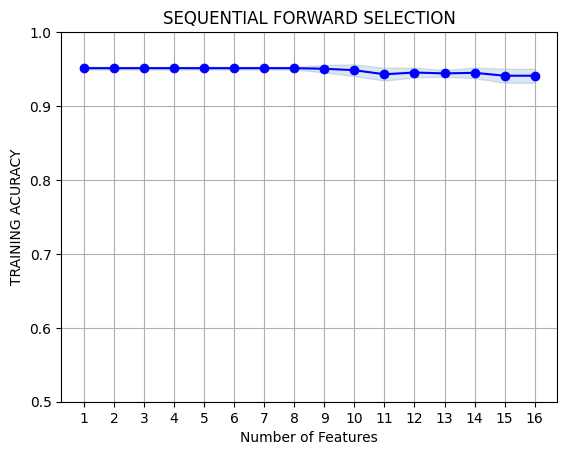

('0',)


In [14]:
fig1 = psfs(sfs_forward.get_metric_dict(),
            ylabel='TRAINING ACURACY',
            kind='std_dev')

plt.ylim([0.5,1])
plt.title('SEQUENTIAL FORWARD SELECTION')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

From the graph above, it is evident that the accuracy remains constant for all features and drops slightly from (`14-17`) features.

`TRANSFORMING THE DATASET USING THE SELECTED FEATURES`

In [15]:
X_train_sfs = sfs_forward.transform(X_train)
X_test_sfs = sfs_forward.transform(X_test)

kNN_sfs = kNN.fit(X_train_sfs, y_train)
pred = kNN.predict(X_test_sfs)
acc_SFS = accuracy_score(pred, y_test)
cv_acc_SFS = cross_val_score(kNN, X_train_sfs,y_train, cv=10)

print('X_train Shape: ', X_train_sfs.shape)
print('X_val on SFS all features: {0:.3f}'.format(cv_acc_SFS.mean()))
print('Hold Out Testing: {0:2d} features selected using SFS: {1:.3f}'.format(len(sfs_forward.k_feature_idx_), acc_SFS))

X_train Shape:  (2543, 1)
X_val on SFS all features: 0.951
Hold Out Testing:  1 features selected using SFS: 0.951


## 6. BACKWARD ELIMINATION

Done by setting the SFS `forward` parameter to `False`

In [16]:
sfs_backward = sfs(kNN, 
                   k_features=(1,max_k),
                   forward=False,
                   floating=False, 
                   verbose=x,
                   scoring='accuracy',
                   cv=10, n_jobs=-1)


sfs_backward = sfs_backward.fit(X_train, y_train)

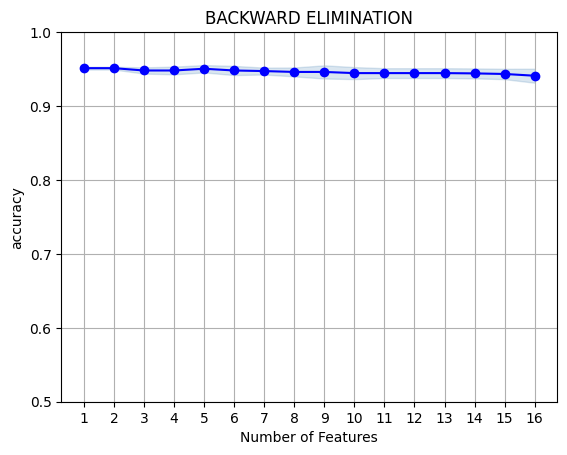

('5', '9')


In [17]:
fig = psfs(sfs_backward.get_metric_dict(),
           ylabel='accuracy',
           kind='std_dev')

plt.ylim([0.5,1])
plt.title('BACKWARD ELIMINATION')
plt.grid()
plt.show()
print(sfs_backward.k_feature_names_)

`TRANSFORMING THE DATASET USING THE SELECTED COLUMNS`

In [18]:
X_train_be = sfs_backward.transform(X_train)
X_test_be = sfs_backward.transform(X_test)

kNN_be = kNN.fit(X_train_be, y_train)
pred = kNN_be.predict(X_test_be)
acc_BE = accuracy_score(pred, y_test)
cv_acc_BE = cross_val_score(kNN, X_train_be, y_train, cv=10)

print(f'X_train shape: {X_train_be.shape}')
print('X_val on BE all features: {0: .3f}'.format(cv_acc_BE.mean()))
print('Hold Out testing: {0:2d} features selected using BE: {1:.3F}'.format(len(sfs_backward.k_feature_idx_), acc_BE))

X_train shape: (2543, 2)
X_val on BE all features:  0.951
Hold Out testing:  2 features selected using BE: 0.951


There isn't any significant change in accuracy for bothe the SFS and BE.

# PLOTTING THE OVERALL RESULTS

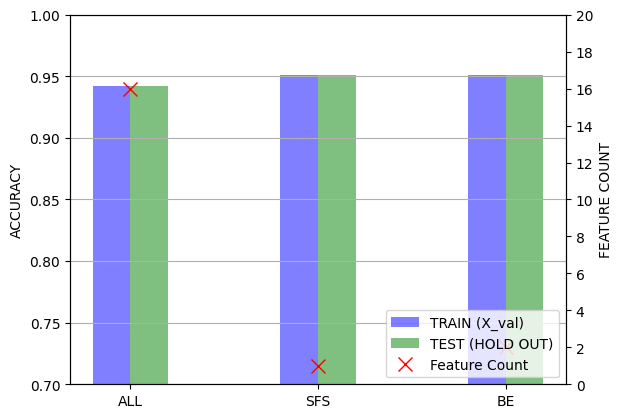

In [19]:
fig, ax = plt.subplots()
width = 0.2

options = ['ALL', 'SFS', 'BE']
n_feat = [X_train.shape[1], X_train_sfs.shape[1], X_train_be.shape[1]]
accs = [acc, acc_SFS, acc_BE]
xv = [cv_acc.mean(), cv_acc_SFS.mean(), cv_acc_BE.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label='TRAIN (X_val)',
            color=['blue', 'blue', 'blue'], alpha=0.5)

p2 = ax.bar(y_pos+width/2, accs, width, align='center', label='TEST (HOLD OUT)',
            color = ['g', 'g', 'g'], alpha=0.5)

ax.set_ylim([0.7,1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2], n_feat, color = 'red', label = 'Feature Count',
              marker = 'x', ms = 10, linewidth=0)

ax2.set_ylim([0, 20])

ax.grid(axis='y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('ACCURACY')
ax2.set_ylabel('FEATURE COUNT')

plt.show()

In [20]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2544
           1       0.00      0.00      0.00         0

    accuracy                           0.95      2544
   macro avg       0.50      0.48      0.49      2544
weighted avg       1.00      0.95      0.97      2544



C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
